In [902]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [903]:
DATA_PATH = os.environ.get("RESEARCH_DATA_PATH")

In [904]:
# Define the start and end dates for the data range
start_date = '1985-01-31'
end_date = '2018-12-31'

# Specify the proportion of test data (e.g., 10%)
test_data_size = 0.2

# Set the number of splits for K-Fold Cross Validation
KFold_split = 5

# Specify a range of alpha values for Ridge regression
alphas = [10**-5, 10**-4, 10**-3, 10**-2, 10**-1, 10**0, 10**1, 10**2, 10**3, 10**4, 10**5]

In [905]:
# Upload X and y data
X_mef = pd.read_csv(f'{DATA_PATH}/processed/mef_monthly_data_processed.csv')
X_mai = pd.read_csv(f'{DATA_PATH}/processed/mai_monthly_data_processed.csv')
y_mkt = pd.read_csv(f'{DATA_PATH}/processed/mkt_monthly_data_processed.csv')

X_mef['date'] = pd.to_datetime(X_mef['date'])
X_mai['date'] = pd.to_datetime(X_mai['date'])
y_mkt['date'] = pd.to_datetime(y_mkt['date'])

X_mef = X_mef[(X_mef['date'] >= start_date) & (X_mef['date'] <= end_date)]
X_mai = X_mai[(X_mai['date'] >= start_date) & (X_mai['date'] <= end_date)]
y_mkt = y_mkt[(y_mkt['date'] >= start_date) & (y_mkt['date'] <= end_date)]

# Drop the 'date' column from each dataset
X_mef = X_mef.drop('date', axis=1)
X_mai = X_mai.drop('date', axis=1)
y_mkt = y_mkt.drop('date', axis=1)

# Drop the 'GSPCprem' colum from y_mkt
y_mkt = y_mkt.drop('GSPCprem', axis=1)

X_mef = X_mef.values
X_mai = X_mai.values
y_mkt = y_mkt.values

In [906]:
def split_data(X, y, train_size, indices):
    # Split indices into train and test indices
    train_indices, test_indices = indices[:train_size], indices[train_size:]

    # Split data based on the indices
    X_train, X_test = X[train_indices], X[test_indices]
    y_train, y_test = y[train_indices], y[test_indices]

    return X_train, y_train, X_test, y_test

In [907]:
def find_optimal_ridge_hyperparameters(X_train, y_train, alphas, KFold_split):
    optimal_degree = None
    optimal_alpha = None
    minimal_mse = float('inf')

    scaler = StandardScaler()
    X_train_std = scaler.fit_transform(X_train)

    for alpha in alphas:
        kf = KFold(n_splits=KFold_split)
        mse_arr = []

        for train_index, test_index in kf.split(X_train_std):
            X_train_n, y_train_n = X_train_std[train_index], y_train[train_index]
            X_train_v, y_train_v = X_train_std[test_index], y_train[test_index]

            # Train Ridge regression
            ridge = Ridge(alpha=alpha)
            ridge.fit(X_train_n, y_train_n)

            # Predict and calculate MSE on the validation set
            y_pred = ridge.predict(X_train_v)
            mse = mean_squared_error(y_train_v, y_pred)
            mse_arr.append(mse)

        # Calculate the average MSE across KFold splits
        avg_mse = np.mean(mse_arr)

        # Update optimal hyperparameters if the current setup is better
        if avg_mse < minimal_mse:
            optimal_alpha = alpha
            minimal_mse = avg_mse

    return optimal_alpha, minimal_mse

In [908]:
def train_and_evaluate_ridge(X_train, y_train, X_test, y_test, alpha):
    # Train Ridge regression on the entire training set
    ridge = Ridge(alpha=alpha)
    ridge.fit(X_train, y_train)
    print(f" MEF Coefficients: {ridge.coef_}")


    # Predict on the training and test sets
    y_pred_train = ridge.predict(X_train)
    y_pred_test = ridge.predict(X_test)

    # Calculate and print MSE for the training and test sets
    mse_train = mean_squared_error(y_train, y_pred_train)
    mse_test = mean_squared_error(y_test, y_pred_test)

    return mse_train, mse_test

In [909]:
def predict_with_ridge(model, scaler, new_X):
    # Standardize the new_X using the same scaler used for training
    new_X_std = scaler.transform(new_X.reshape(1, -1))

    # Predict the target value using the trained Ridge model
    predicted_y = model.predict(new_X_std)

    return predicted_y[0]

In [910]:
# Get same random split of MEF and MAI data
N = X_mef.shape[0]
train_size = int((1-test_data_size) * N)
indices = np.random.permutation(N)

In [911]:
# Training and evaluating Ridge model: MEF

MEF_errors_train = []
MEF_errors_test = []
MAI_errors_train = []
MAI_errors_test = []

for i in range(10):
    # Split data into training and test sets
    np.random.shuffle(indices)
    X_train_mef, y_train_mef, X_test_mef, y_test_mef = split_data(X_mef, y_mkt, train_size, indices)
    X_train_mai, y_train_mai, X_test_mai, y_test_mai = split_data(X_mai, y_mkt, train_size, indices)

    # Standardize both training and test data using a scaler
    scaler = StandardScaler()
    X_train_std_mef = scaler.fit_transform(X_train_mef)
    X_test_std_mef = scaler.transform(X_test_mef)  
    X_train_std_mai = scaler.fit_transform(X_train_mai)
    X_test_std_mai = scaler.transform(X_test_mai)

    # Find optimal alpha using cross-validation
    optimal_alpha_mef, minimal_mse_mef = find_optimal_ridge_hyperparameters(X_train_std_mef, y_train_mef, alphas, KFold_split)    
    optimal_alpha_mai, minimal_mse_mai = find_optimal_ridge_hyperparameters(X_train_std_mai, y_train_mai, alphas, KFold_split)

    minimal_rmse_mef = minimal_mse_mef**(1/2)
    #print(f"Optimal alpha for MEF data: {optimal_alpha_mef}, Minimal MSE: {minimal_rmse_mef}")    
    minimal_rmse_mai = minimal_mse_mai**(1/2)
    #print(f"Optimal alpha for MAI data: {optimal_alpha_mai}, Minimal MSE: {minimal_rmse_mai}")
    
    # Evaluate the model on the test set
    mse_train_mef, mse_test_mef = train_and_evaluate_ridge(X_train_std_mef, y_train_mef, X_test_std_mef, y_test_mef, optimal_alpha_mef)
    rmse_train_mef = mse_train_mef**(1/2)
    rmse_test_mef = mse_test_mef**(1/2)
    
    MEF_errors_train.append(rmse_train_mef)
    MEF_errors_test.append(rmse_test_mef)

    #print(f"Train RMSE for MEF data: {rmse_train_mef}")
    #print(f"Test RMSE for MEF data: {rmse_test_mef}")
    #print("")
    
    
    mse_train_mai, mse_test_mai = train_and_evaluate_ridge(X_train_std_mai, y_train_mai, X_test_std_mai, y_test_mai, optimal_alpha_mai)
    rmse_train_mai = mse_train_mai**(1/2)
    rmse_test_mai = mse_test_mai**(1/2)
    
    MAI_errors_train.append(rmse_train_mai)
    MAI_errors_test.append(rmse_test_mai)

    #print(f"Train RMSE for MAI data: {rmse_train_mai}")
    #print(f"Test RMSE for MAI data: {rmse_test_mai}")
    #print("")

    # Save the trained model and scaler for later use
    ridge_scaler = scaler

    
MEF_avg_rmse_train = sum(MEF_errors_train) / len(MEF_errors_train)   
MEF_avg_rmse_test = sum(MEF_errors_test) / len(MEF_errors_test)
print('MEF Linear Predictor')
print(f"Average Train RMSE for MEF data: {MEF_avg_rmse_train}")
print(f"Average Test RMSE for MEF data: {MEF_avg_rmse_test}")
print("")

MAI_avg_rmse_train = sum(MAI_errors_train) / len(MAI_errors_train)
MAI_avg_rmse_test = sum(MAI_errors_test) / len(MAI_errors_test)
print('MAI Linear Predictor')
print(f"Average Train RMSE for MAI data: {MAI_avg_rmse_train}")
print(f"Average Test RMSE for MAI data: {MAI_avg_rmse_test}")
print("")

 MEF Coefficients: [[ 0.00867955  0.00876961  0.00635737  0.00089854 -0.01498724  0.00627156
   0.00497258 -0.00104921 -0.00090041  0.00173593  0.00051826 -0.00760567
   0.00705917  0.00103018]]
 MEF Coefficients: [[-0.00457395 -0.00120002 -0.00153072  0.00136501 -0.0016262  -0.00013552
   0.00339395 -0.00934224]]
 MEF Coefficients: [[ 2.55766266  1.81780578  1.8914784   0.25644227 -4.50436061  0.93358762
   2.04984832 -1.36439719 -2.4534432   2.70460405 -1.62701882 -1.60394693
   4.73452208 -0.89967841]]
 MEF Coefficients: [[-0.00641942 -0.00373798  0.00096356 -0.00544287 -0.01108704 -0.00065854
   0.00393359 -0.00749984]]
 MEF Coefficients: [[ 0.01086162  0.01086694  0.00532783  0.00378873 -0.01950903  0.00985097
   0.00906616 -0.00443501 -0.00400978  0.00463178  0.0020373  -0.00330444
   0.01215975  0.00218272]]
 MEF Coefficients: [[-7.95780891e-05  1.25461038e-03 -4.64611016e-04  3.55265926e-03
  -9.60276234e-03  4.64339609e-04  9.30776456e-03 -4.82944621e-03]]
 MEF Coefficients: [

               credit_rating       gdp  house_mkt  inflation  monetary  \
credit_rating       1.000000  0.125838   0.205368   0.026673  0.123901   
gdp                 0.125838  1.000000   0.142408   0.289668  0.256832   
house_mkt           0.205368  0.142408   1.000000   0.012346  0.163980   
inflation           0.026673  0.289668   0.012346   1.000000  0.305518   
monetary            0.123901  0.256832   0.163980   0.305518  1.000000   
oil                 0.096927  0.164988   0.090642   0.275299  0.209568   
unemp               0.111112  0.196041   0.040230   0.166721  0.168321   
usd                -0.056676  0.106366   0.032586   0.180514  0.135655   

                    oil     unemp       usd  
credit_rating  0.096927  0.111112 -0.056676  
gdp            0.164988  0.196041  0.106366  
house_mkt      0.090642  0.040230  0.032586  
inflation      0.275299  0.166721  0.180514  
monetary       0.209568  0.168321  0.135655  
oil            1.000000 -0.025651  0.249319  
unemp      

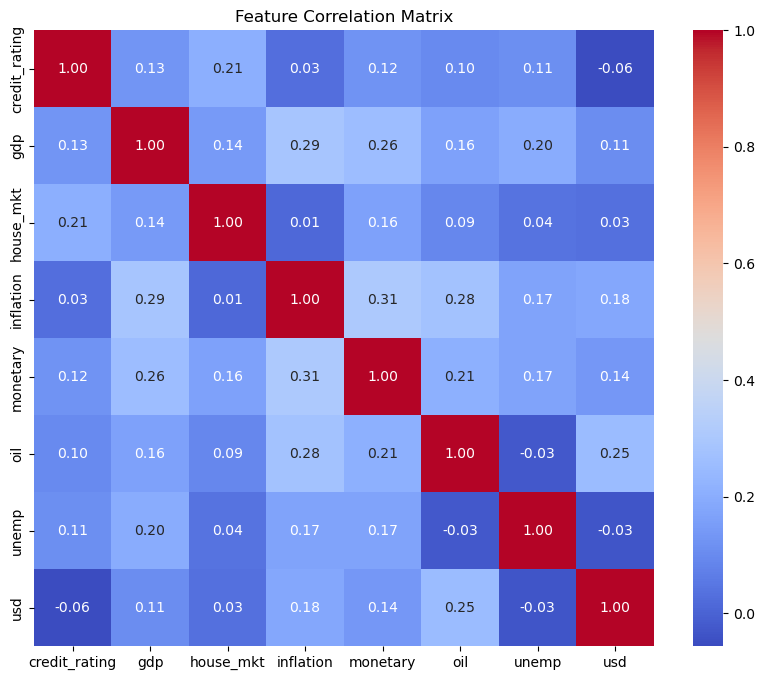

In [912]:

df = pd.DataFrame(X_mai, columns=['credit_rating', 'gdp', 'house_mkt', 'inflation', 'monetary', 'oil', 'unemp', 'usd'])  # replace 'col1', 'col2', etc. with your actual column names

corr_matrix = df.corr()

print(corr_matrix)

# heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Feature Correlation Matrix")
plt.show()
